# Scaling XGBoost with Dask and Coiled

This notebook walks through training an [XGBoost](https://xgboost.readthedocs.io/en/latest/) model locally on a small dataset and then using [Dask](https://dask.org/) and [Coiled](https://coiled.io/) to scale out to the cloud and run XGBoost on a larger-than-memory dataset.

# Generate our dataset

In [1]:
# import pandas as pd

# column_names = ["label"] + [f"feature-{i}" for i in range(28)]
# df = pd.read_csv("HIGGS.csv",
#                  nrows=100_000,
#                  names=column_names,
# #                  dtype={"label": "category"},
#                 )
# df

In [2]:
# X, y = df.iloc[:, 1:], pd.get_dummies(df["label"]).iloc[:, 1]

In [3]:
# import pandas as pd

# df = pd.read_csv(
#     "s3://nyc-tlc/trip data/yellow_tripdata_2019-01.csv",
#     parse_dates=["tpep_pickup_datetime", "tpep_dropoff_datetime"],
# #     dtype={
# #         "payment_type": "UInt8",
# #         "VendorID": "UInt8",
# #         "passenger_count": "UInt8",
# #         "RatecodeID": "UInt8",
# #         "store_and_fwd_flag": "category",
# #         "PULocationID": "UInt16",
# #         "DOLocationID": "UInt16",
# #     },
#     nrows=100,
# )

In [4]:
# df

In [5]:
# columns = ["passenger_count", "trip_distance", "fare_amount", "tolls_amount", "PULocationID", "DOLocationID"]
# X, y = df[columns], df["tip_amount"]

In [27]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(n_samples=100_000,
                           n_features=40,
                           n_informative=10,
                           random_state=2)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Local XGBoost

[XGBoost](https://xgboost.readthedocs.io/en/latest/) is a popular library for training gradient boosted supervised machine learning models. To use XGBoost, we'll first construct `xgboost.DMatrix` objects for our training and testing datasets. Since XGBoost plays well with libaries like NumPy and Pandas, we can simply pass our training and testing datasets directly to `xgboost.DMatrix`.

In [28]:
import xgboost

In [29]:
dtrain = xgboost.DMatrix(X_train, y_train)
dtest = xgboost.DMatrix(X_test, y_test)

Next we'll define the set of hyperparameters we want to use for our XGBoost model and use our training dataset to train a model!

In [30]:
params = {'objective': 'binary:logistic',
          'max_depth': 2,
          'min_child_weight': 0.5}

In [31]:
bst = xgboost.train(params, dtrain, num_boost_round=2)

We can now use our trained model to make predictions on the testing dataset which _not_ used to train the model.

In [32]:
y_pred = bst.predict(dtest)

In [33]:
y_pred

array([0.3055497 , 0.3055497 , 0.4884934 , ..., 0.3055497 , 0.47768047,
       0.3055497 ], dtype=float32)

To get a sense for the quality of these predictions we can compute and plot a [receiver operating characteristic (ROC) curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) of our model's predictions, which compares the predicted output from our model with the known labels to calculate the true postive rate vs. false positive rate.

In [34]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, y_pred)

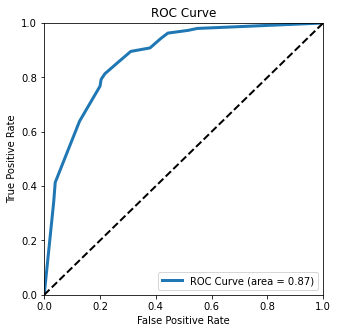

In [35]:
from sklearn.metrics import auc
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(fpr, tpr, lw=3,
        label='ROC Curve (area = {:.2f})'.format(auc(fpr, tpr)))
ax.plot([0, 1], [0, 1], 'k--', lw=2)
ax.set(
    xlim=(0, 1),
    ylim=(0, 1),
    title="ROC Curve",
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)
ax.legend()
plt.show()

# Scaling with Dask and Coiled

In the previous section, we trained a model on a modestly sized dataset of 100,000 samples, each with 40 features. In this section, we will scale up the size of our dataset to 100 million samples to simulate more real world conditions. With this increased number of samples, we'll not (typically) be able to load the dataset comfortably fit into memory on a personal laptop. As such, we'll use Dask and Coiled to expand our compute resources to the cloud to enable us to work with this larger datset.

### Generate a large dataset

Dask's machine learning library, [Dask-ML](https://ml.dask.org/), mimics Scikit-learn's API, providing scalable versions of functions of `sklearn.datasets.make_classification` and `sklearn.model_selection.train_test_split` that are designed to work with Dask Arrays and DataFrames in larger-than-memory settings.

Let's use Dask-ML to generate a similar classification dataset as before, but now with 100 million samples.

In [36]:
from dask_ml.datasets import make_classification
from dask_ml.model_selection import train_test_split

X, y = make_classification(n_samples=100_000_000,
                           n_features=40,
                           n_informative=10,
                           random_state=0,
                           chunks=100_000)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

This dataset is 32.8 GB in size, which is large enough to merit scaling out our compute resources.

In [37]:
(X.nbytes + y.nbytes) / 1e9

32.8

### Create a Dask cluster on AWS with Coiled

Let's create a Coiled cluster using the `jrbourbeau/xgboost` cluster configuration, which has Dask, XGBoost, Scikit-learn, and other relavant packages installed, and then connect a `dask.distributed.Client` to our cluster so we can begin to submit tasks to the cluster.

In [17]:
import coiled
import dask.distributed

cluster = coiled.Cluster(n_workers=20, configuration="jrbourbeau/xgboost")
client = dask.distributed.Client(cluster)
client

In [19]:
client

Client Scheduler: tls://ec2-3-17-176-132.us-east-2.compute.amazonaws.com:8786 Dashboard: http://ec2-3-17-176-132.us-east-2.compute.amazonaws.com:8787/status,Cluster Workers: 20 Cores: 80 Memory: 343.60 GB


Be sure to click te "Dashboard:" link above to view the diagnostics dashboard for your cluster. This will show what tasks are currently being processed, how much memory your workers are using, etc.

Next we'll [persist our training and testing datasets](https://distributed.dask.org/en/latest/memory.html#persisting-collections) into distributed memory to avoid any unnecessary re-computations.

In [39]:
import dask

X_train, X_test, y_train, y_test = dask.persist(X_train, X_test, y_train, y_test)

In [40]:
X_train

,Array,Chunk
Bytes,25.60 GB,25.60 MB
Shape,"(80000000, 40)","(80000, 40)"
Count,1000 Tasks,1000 Chunks
Type,float64,numpy.ndarray


To do distributed training of an XGBoost model, we'll use the [Dask-XGBoost](https://github.com/dask/dask-xgboost) package which mirrors XGBoost's interface but works with Dask Arrays and DataFrames.

In [41]:
import dask_xgboost

In [42]:
bst = dask_xgboost.train(client, params, X_train, y_train, num_boost_round=2)

Again we can compute and plot the ROC curve for this model's predictions.

In [43]:
y_pred = dask_xgboost.predict(client, bst, X_test).persist()

In [44]:
from sklearn.metrics import roc_curve

y_test, y_pred = dask.compute(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test, y_pred)

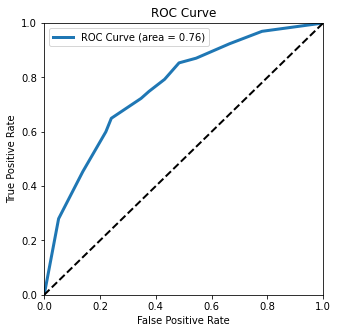

In [45]:
from sklearn.metrics import auc

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(fpr, tpr, lw=3,
        label='ROC Curve (area = {:.2f})'.format(auc(fpr, tpr)))
ax.plot([0, 1], [0, 1], 'k--', lw=2)
ax.set(
    xlim=(0, 1),
    ylim=(0, 1),
    title="ROC Curve",
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)
ax.legend()
plt.show()

Voilà! Congratulations on training a boosted decision tree on a larger-than-memory dataset in the cloud from JupyterLab